In [2]:
import mne
import os
import os.path as op
import numpy as np
from mne.time_frequency import tfr_morlet, csd_morlet
import matplotlib.pyplot as plt
import pickle
from sys import argv
from warnings import filterwarnings
#matplotlib.use('Qt4Agg')
filterwarnings("ignore", category=DeprecationWarning)

In [177]:
project_dir = '/Users/dariq/Dropbox/PC/Documents/projects/working_memory'
raw_path = '/Users/dariq/Dropbox/MEG_music_imagination_data/01_raw_maxfiltered'
ica_path = '/Users/dariq/Dropbox/MEG_music_imagination_data/02_ica_solution'
sub = '0013_NHJ'

In [178]:
conds = ['main','inv']
# args = argv[0]
# sub, conds, suffix = args['sub'], args['conds'], args['suffix']
# save_averages, compute_sources = args['save_averages'], args['compute_sources']
# save_sources, plot_sources = args['save_sources','plot_sources']

event_ids = [[['recall/same',1],['recall/different',2]],[['manipulation/inverted',3],['manipulation/other',4]]]

epochs = {}
power = {}
for cidx, c in enumerate(conds):
    fname = os.path.join(raw_path, sub, c + '_raw_tsss.fif')
    icaname = os.path.join(ica_path,sub, c + '_raw_tsss-ica.fif')
    raw = mne.io.read_raw_fif(fname, preload = True) # load data
    ica = mne.preprocessing.read_ica(icaname) # load ica solution
    raw = ica.apply(raw) # apply ICA
    #raw.plot()
    raw.resample(350)

    # Get and correct triggers:
    events = mne.find_events(raw, shortest_event = 1)
    events = events[np.append(np.diff(events[:,0]) >2,True)] # delete spurious t
    events2 = events.copy()
    events2 = events2[events[:,2] < 20]
    events2[:,2] = events[np.isin(events[:,2]//10,[11,21]),2]//100 + cidx*2# recode events

    event_id = dict(event_ids[cidx])
    picks = mne.pick_types(raw.info, meg = True)
    tmin, tmax = -1,6.5 #epoch time
    baseline = (-1,0) # baseline time
    reject = dict(mag = 8e-12, grad = 4000e-13)#eeg = 200e-6, #, eog = 250e-6)

    #epoching:
    epochs[c] = mne.Epochs(raw, events = events2, event_id = event_id,
                    tmin = tmin, tmax = tmax, picks = picks,
                    baseline = baseline, reject = reject)

Opening raw data file /Users/dariq/Dropbox/MEG_music_imagination_data/01_raw_maxfiltered\0013_NHJ\main_raw_tsss.fif...
    Range : 11000 ... 527999 =     11.000 ...   527.999 secs
Ready.
Reading 0 ... 516999  =      0.000 ...   516.999 secs...
Reading /Users/dariq/Dropbox/MEG_music_imagination_data/02_ica_solution\0013_NHJ\main_raw_tsss-ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (27 components)
    Zeroing out 2 ICA components
    Projecting back using 306 PCA components
360 events found
Event IDs: [ 11  13  22  31  33 111 113 122 131 133 211 213 221 222 223 231 232 233]
360 events found
Event IDs: [ 11  13  22  31  33 111 113 122 131 133 211 213 221 222 223 231 232 233]
360 events found
Event IDs: [ 11  13  22  31  33 111 113 122 131 133 211 213 221 222 223 231 232 233]
Not setting metadata
Not setting metadata
60 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Opening raw da

In [179]:
all_epochs = mne.concatenate_epochs([epochs[e] for e in epochs])

Loading data for 60 events and 2626 original time points ...
    Rejecting  epoch based on MAG : ['MEG1641', 'MEG2411']
    Rejecting  epoch based on MAG : ['MEG1331', 'MEG1341', 'MEG1611', 'MEG1621', 'MEG1631', 'MEG1641', 'MEG2321', 'MEG2411', 'MEG2421', 'MEG2431', 'MEG2441', 'MEG2521', 'MEG2611', 'MEG2641']
    Rejecting  epoch based on MAG : ['MEG1121', 'MEG1131', 'MEG1231', 'MEG1241', 'MEG1311', 'MEG1331', 'MEG1341', 'MEG1611', 'MEG1621', 'MEG1631', 'MEG1641', 'MEG1721', 'MEG1911', 'MEG1941', 'MEG2321', 'MEG2411', 'MEG2421', 'MEG2431', 'MEG2441', 'MEG2521', 'MEG2611', 'MEG2641']
    Rejecting  epoch based on MAG : ['MEG1331', 'MEG1341', 'MEG1611', 'MEG1621', 'MEG1631', 'MEG1641', 'MEG2411', 'MEG2421', 'MEG2431', 'MEG2441', 'MEG2521', 'MEG2641']
    Rejecting  epoch based on MAG : ['MEG2411', 'MEG2431']
    Rejecting  epoch based on MAG : ['MEG1121', 'MEG1131', 'MEG1311', 'MEG1331', 'MEG1341', 'MEG1621', 'MEG1631', 'MEG1641', 'MEG1721', 'MEG1941', 'MEG2321', 'MEG2411', 'MEG2421', 'M

In [180]:
#freqs = [70,80,90,100,110,120,130,140,150]
freqs = np.array([1,2,3,4,5,6,7,8,9,10,12,14,16,18,20,22,24,26,28,30,35,40,45,50,60,70,80,90,100,110,120,130,140,150])
#freqs = np.logspace(*np.log10([2,100]),20)
n_cycles = freqs/2.

power =  tfr_morlet(all_epochs, freqs = freqs, n_cycles= n_cycles,
                           use_fft = True,return_itc = False, decim = 4,
                           average = False, n_jobs=4)


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    2.9s
[Parallel(n_jobs=4)]: Done  68 tasks      | elapsed:    5.8s
[Parallel(n_jobs=4)]: Done 158 tasks      | elapsed:   10.9s
[Parallel(n_jobs=4)]: Done 284 tasks      | elapsed:   18.3s
[Parallel(n_jobs=4)]: Done 306 out of 306 | elapsed:   19.5s finished


Not setting metadata


In [181]:
for p in range(power.data.shape[0]):
    print('log transforming trial ', p+1)
    power.data[p] = np.log(power.data[p])

log transforming trial  1
log transforming trial  2
log transforming trial  3
log transforming trial  4
log transforming trial  5
log transforming trial  6
log transforming trial  7
log transforming trial  8
log transforming trial  9
log transforming trial  10
log transforming trial  11
log transforming trial  12
log transforming trial  13
log transforming trial  14
log transforming trial  15
log transforming trial  16
log transforming trial  17
log transforming trial  18
log transforming trial  19
log transforming trial  20
log transforming trial  21
log transforming trial  22
log transforming trial  23
log transforming trial  24
log transforming trial  25
log transforming trial  26
log transforming trial  27
log transforming trial  28
log transforming trial  29
log transforming trial  30
log transforming trial  31
log transforming trial  32
log transforming trial  33
log transforming trial  34
log transforming trial  35
log transforming trial  36
log transforming trial  37
log transf

In [182]:
print('z-scoring data')
baseline = [-.8,0]
bix = np.where((power.times >= baseline[0]) & (power.times < baseline[1]))[0]
cmean = power.data[:,:,:,bix].mean(axis=3,keepdims=True)
csdev = power.data[:,:,:,bix].std(axis=3,keepdims=True)
power.data -= cmean
power.data /= csdev


z-scoring data


In [183]:
#power.average().plot_joint()
bands = {'delta': [1,4],
         'theta': [4,8],
         'alpha': [8,12],
         'beta1': [12,20],
         'beta2': [20,30],
         'gamma1': [30,60],
         'gamma2': [70,150]}
band_power = {}
for b in bands:
    bix = np.where((power.freqs > bands[b][0]) & (power.freqs <= bands[b][1]))[0]
    print(power.freqs[bix])
    band_power[b] = mne.EpochsArray(power.data[:,:,bix,:].mean(axis=2),info=power.info,events=power.events,event_id=power.event_id,tmin=-1)

[2. 3. 4.]
Not setting metadata
Not setting metadata
101 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
[5. 6. 7. 8.]
Not setting metadata
Not setting metadata
101 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
[ 9. 10. 12.]
Not setting metadata
Not setting metadata
101 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
[14. 16. 18. 20.]
Not setting metadata
Not setting metadata
101 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
[22. 24. 26. 28. 30.]
Not setting metadata
Not setting metadata
101 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
[35. 40. 45. 50. 60.]
Not setting metadata
Not setting metadata
101 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
[ 80.

C:\Users\dariq\AppData\Local\Temp/ipykernel_1580/2918126437.py:1: RuntimeWarning: More than 25 topomaps plots requested. This might take a while.
  band_power['beta1']['recall'].average().plot_topomap(  times=np.arange(-0.5,4,0.1),average=.1,ch_type='mag')


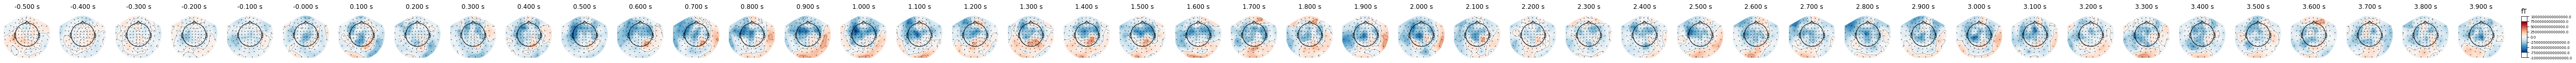

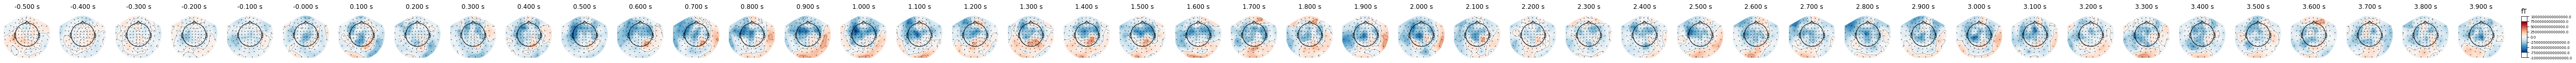

In [184]:
band_power['beta1']['recall'].average().plot_topomap(  times=np.arange(-0.5,4,0.1),average=.1,ch_type='mag')

C:\Users\dariq\AppData\Local\Temp/ipykernel_1580/431457365.py:1: RuntimeWarning: More than 25 topomaps plots requested. This might take a while.
  band_power['beta1']['manipulation'].average().plot_topomap(  times=np.arange(-0.5,4,0.1),average=.1,ch_type='mag')


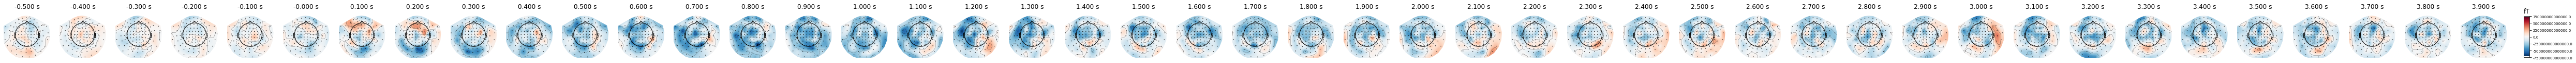

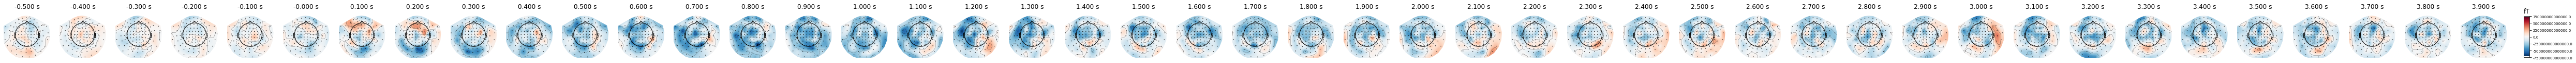

In [185]:
band_power['beta1']['manipulation'].average().plot_topomap(  times=np.arange(-0.5,4,0.1),average=.1,ch_type='mag')

Multiple channel types selected, returning one figure per type.
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied


[<Figure size 432x288 with 3 Axes>, <Figure size 432x288 with 3 Axes>]

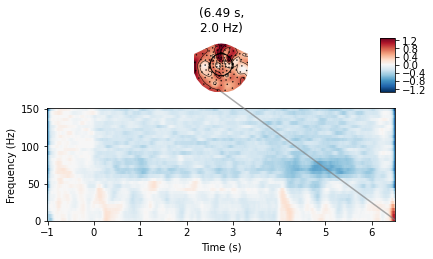

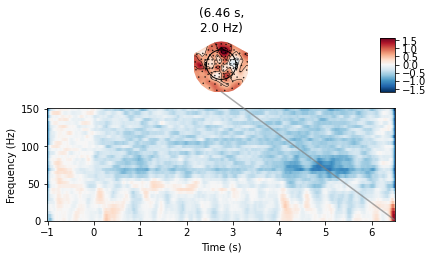

In [192]:
#power['recall'].average().copy().pick_channels(['MEG0221']).plot()
power['recall'].average().plot_joint()

Multiple channel types selected, returning one figure per type.
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied


[<Figure size 432x288 with 3 Axes>, <Figure size 432x288 with 3 Axes>]

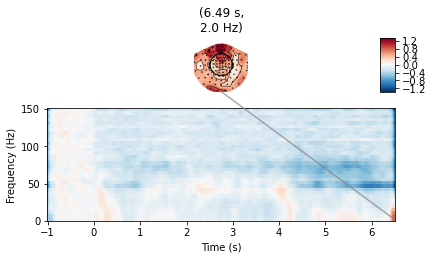

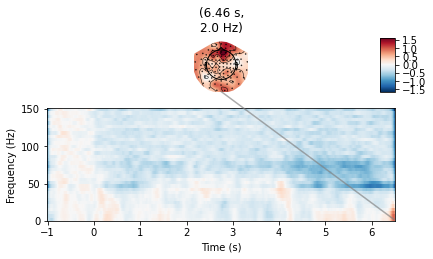

In [191]:
#power['manipulation'].average().copy().pick_channels(['MEG0221']).plot()
power['manipulation'].average().plot_joint()

Not setting metadata
Not setting metadata
52 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
combining channels using "mean"


C:\Users\dariq\AppData\Local\Temp/ipykernel_1580/2002056108.py:1: RuntimeWarning: Only one channel in group "mag"; cannot combine by method "mean".
  band_power['beta1']['recall'].copy().pick_channels(['MEG0221']).plot_image(combine='mean',vmin=-4e15,vmax=4e15)#,vmin=-1e-14,vmax=1e-14)#,vmin=-8e-15,vmax=8e-15)
C:\Users\dariq\AppData\Local\Temp/ipykernel_1580/2002056108.py:1: RuntimeWarning: Only 1 channel in "picks"; cannot combine by method "mean".
  band_power['beta1']['recall'].copy().pick_channels(['MEG0221']).plot_image(combine='mean',vmin=-4e15,vmax=4e15)#,vmin=-1e-14,vmax=1e-14)#,vmin=-8e-15,vmax=8e-15)


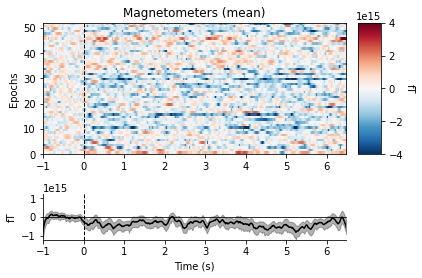

[<Figure size 432x288 with 3 Axes>]

In [190]:
band_power['beta1']['recall'].copy().pick_channels(['MEG0221']).plot_image(combine='mean',vmin=-4e15,vmax=4e15)#,vmin=-1e-14,vmax=1e-14)#,vmin=-8e-15,vmax=8e-15)

Not setting metadata
Not setting metadata
49 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
combining channels using "mean"


C:\Users\dariq\AppData\Local\Temp/ipykernel_1580/2683173087.py:1: RuntimeWarning: Only one channel in group "mag"; cannot combine by method "mean".
  band_power['gamma2']['manipulation'].copy().pick_channels(['MEG1131']).plot_image(combine='mean',vmin=-4e15,vmax=4e15)#,vmin=-1e-14,vmax=1e-14)#,vmin=-8e-15,vmax=8e-15)
C:\Users\dariq\AppData\Local\Temp/ipykernel_1580/2683173087.py:1: RuntimeWarning: Only 1 channel in "picks"; cannot combine by method "mean".
  band_power['gamma2']['manipulation'].copy().pick_channels(['MEG1131']).plot_image(combine='mean',vmin=-4e15,vmax=4e15)#,vmin=-1e-14,vmax=1e-14)#,vmin=-8e-15,vmax=8e-15)


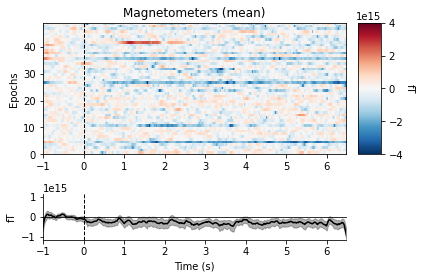

[<Figure size 432x288 with 3 Axes>]

In [189]:
band_power['gamma2']['manipulation'].copy().pick_channels(['MEG1131']).plot_image(combine='mean',vmin=-4e15,vmax=4e15)#,vmin=-1e-14,vmax=1e-14)#,vmin=-8e-15,vmax=8e-15)